In [6]:
import wplus_utils
import torch
from diffusers import StableDiffusionPipeline, DDIMScheduler
import ptp_utils

In [7]:
scheduler = DDIMScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", clip_sample=False, set_alpha_to_one=False, steps_offset=1)
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
ldm_stable = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4", local_files_only=True, scheduler=scheduler, force_download=True).to(device)
try:
    ldm_stable.disable_xformers_memory_efficient_attention()
except AttributeError:
    print("Attribute disable_xformers_memory_efficient_attention() is missing")
tokenizer = ldm_stable.tokenizer

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


In [8]:
image_path = "./example_images/a black bear climb a tree in rain.png"
prompt = "a black bear climb a tree in rain"

matrix_inversion = wplus_utils.MatrixInversion(ldm_stable,inner_steps_num=None,lambda_norm=0e-7,use_freq=False,use_attn_loss=False) #derain 1e-7
(image_gt, image_enc), x_t, uncond_embeddings, w_matrices = matrix_inversion.invert(image_path, prompt, offsets=(0,0,0,0), num_inner_steps=10, verbose=True, learning_rate=1e1)
# w_modify_end(w_matrices,0.5)

DDIM inversion...
Guidance Matrix optimization...


  0%|          | 0/500 [00:00<?, ?it/s]

   step_i: 0 loss: 1.7798991393647157e-05
   step_i: 1 loss: 2.2566391635336913e-05
   step_i: 2 loss: 3.034712244698312e-05
   step_i: 3 loss: 3.257898788433522e-05
   step_i: 4 loss: 3.519693200360052e-05
   step_i: 5 loss: 4.039808118250221e-05
   step_i: 6 loss: 4.620334584615193e-05
   step_i: 7 loss: 5.1561488362494856e-05
   step_i: 8 loss: 5.43288879271131e-05
   step_i: 9 loss: 5.241398685029708e-05
   step_i: 10 loss: 4.86282842757646e-05
   step_i: 11 loss: 4.8967332986649126e-05
   step_i: 12 loss: 4.911777068627998e-05
   step_i: 13 loss: 4.925346001982689e-05
   step_i: 14 loss: 5.008289735997096e-05
   step_i: 15 loss: 4.9594098527450114e-05
   step_i: 16 loss: 4.8701629566494375e-05
   step_i: 17 loss: 6.795286026317626e-05
   step_i: 18 loss: 8.283083298010752e-05
   step_i: 19 loss: 7.526521221734583e-05
   step_i: 20 loss: 7.689867925364524e-05
   step_i: 21 loss: 7.792907126713544e-05
   step_i: 22 loss: 7.386345532722771e-05
   step_i: 23 loss: 7.001150515861809e-0

  0%|          | 0/50 [00:00<?, ?it/s]

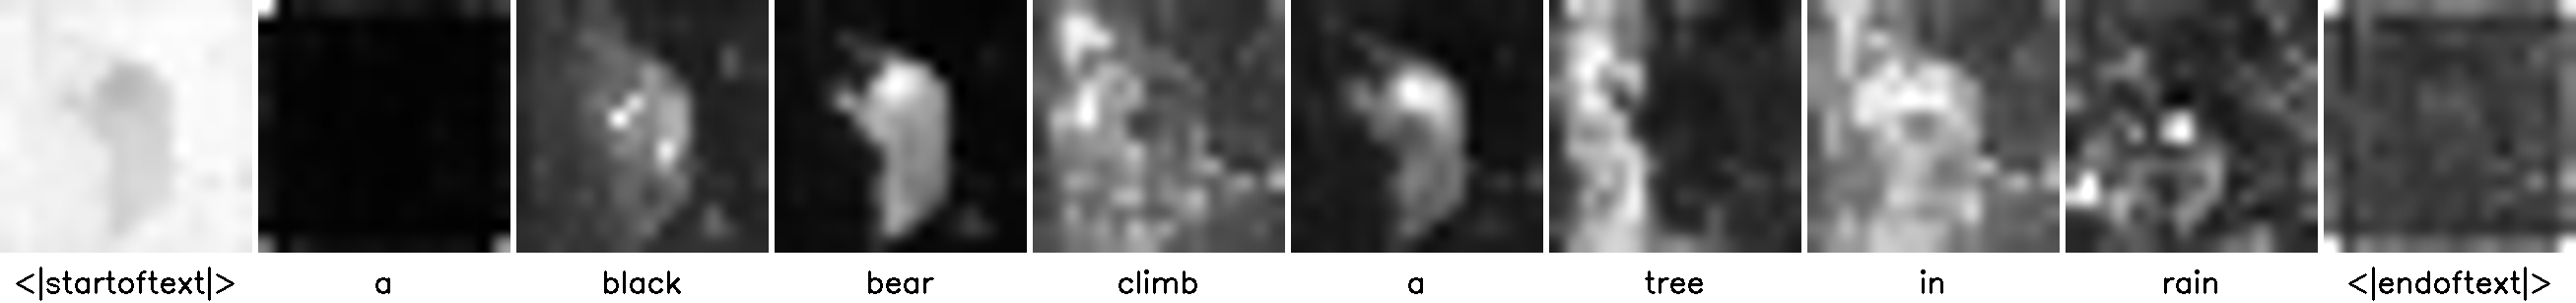

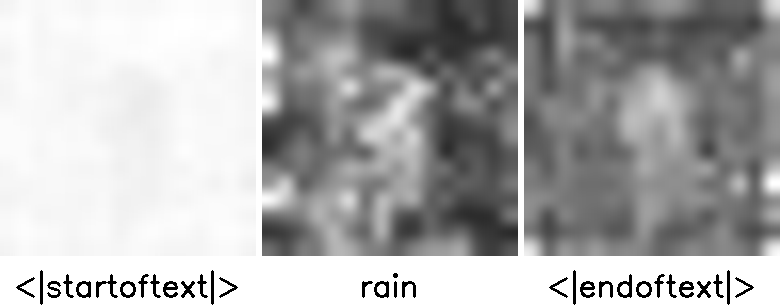

  0%|          | 0/50 [00:00<?, ?it/s]

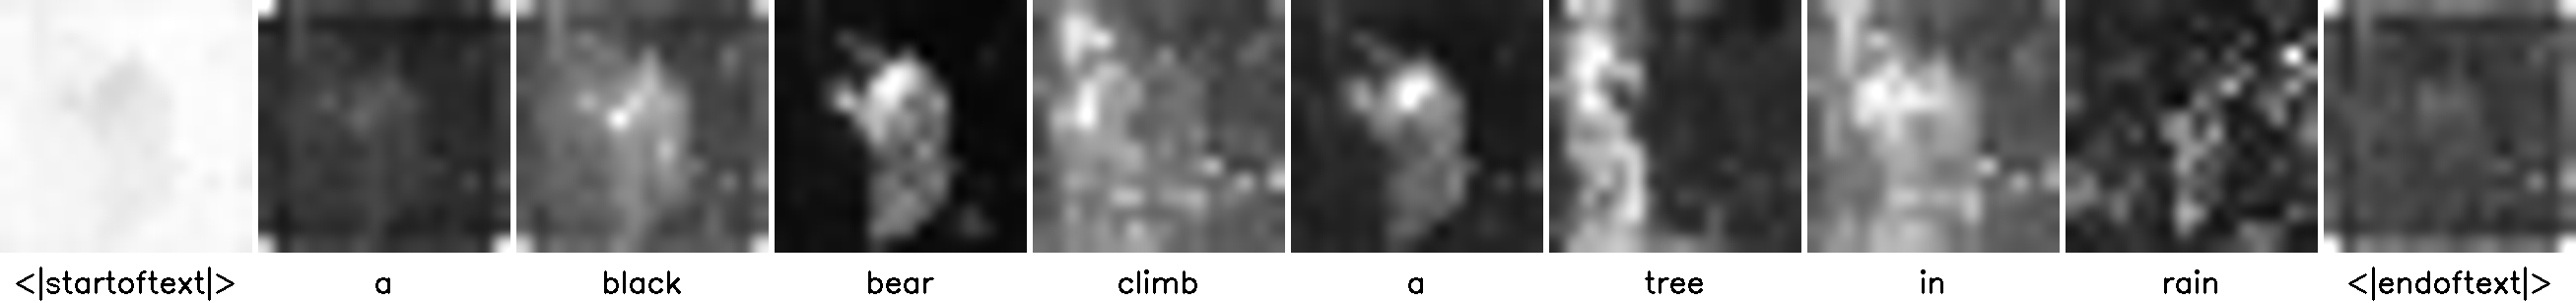

showing from left to right: the ground truth image, w+ reconstruction, w+ derain


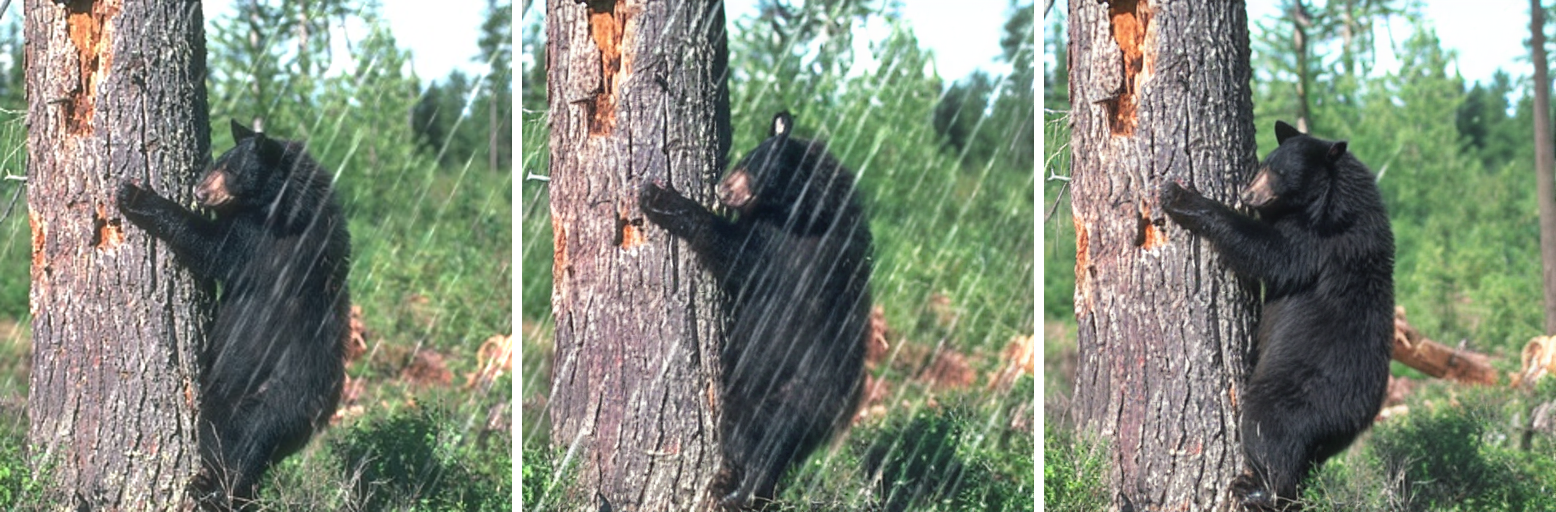

PSNR：21.488643976726323，SSIM：0.6689374152313506，MSE：461.5470326741536


In [9]:
prompts = [prompt]
cross_replace_steps = 0.0
self_replace_steps = 0.0
tao = 0.9
negative_prompt = "rain"

controller = wplus_utils.WplusAttentionStore(cross_replace_steps=cross_replace_steps,self_replace_steps=self_replace_steps)
image_derain, x_t = wplus_utils.run_and_display(ldm_stable, prompts, controller, run_baseline=False, latent=x_t, uncond_embeddings=None, optimize_matrices=w_matrices, negative_prompt=negative_prompt, verbose=False, tao=tao)
wplus_utils.show_cross_attention(controller,16,["up", "down"],prompts,ldm_stable,0,negative_prompt=negative_prompt)
controller = wplus_utils.AttentionStore()
image_inv, x_t = wplus_utils.run_and_display(ldm_stable, prompts, controller, run_baseline=False, latent=x_t, uncond_embeddings=None, optimize_matrices=w_matrices, verbose=False)
wplus_utils.show_cross_attention(controller,16,["up", "down"],prompts,ldm_stable,0)
# show_self_attention_comp(controller,16,["up", "down"],10,0)
print("showing from left to right: the ground truth image, w+ reconstruction, w+ derain")
ptp_utils.view_images([image_gt, image_inv[0], image_derain[0]])

p = wplus_utils.compare_psnr(image_gt, image_inv[0])
s = wplus_utils.compare_ssim(image_gt, image_inv[0], multichannel=True, channel_axis=2)  # 对于多通道图像(RGB、HSV等)关键词multichannel要设置为True
m = wplus_utils.compare_mse(image_gt, image_inv[0])
 
print('PSNR：{}，SSIM：{}，MSE：{}'.format(p, s, m))